In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

%cd ~/Codes/DL/Pytorch

/Users/one/Codes/DL/Pytorch


In [3]:
df = pd.read_csv('data/kospi.csv') # kospi 데이터 불러오기

scaler = MinMaxScaler() # 최대최소 정규화 진행
df[['Open','High','Low','Close','Volume']] = scaler.fit_transform(df[['Open','High','Low','Close','Volume']])

In [4]:
device = torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu')
print(f'{device} is available')

mps:0 is available


In [5]:
X = df[['Open','High','Low','Volume']].values
y = df['Close'].values # target data

In [6]:
def seq_data(x, y, sequence_length):

    x_seq = []
    y_seq = []

    for i in range(len(x) - sequence_length): # sequence 길이 5, 5일간의 값으로 예측
        x_seq.append(x[i: i+sequence_length]) # 5*5의 X
        y_seq.append(y[i+sequence_length]) # 5*1의 y
    return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view([-1, 1]) # Float형 Tensor 변환, GPU 사용

In [7]:
split = 200 # split 200 기준, train data와 test data로 나눔
sequence_length = 5

x_seq, y_seq = seq_data(X, y, sequence_length)

x_train_seq = x_seq[:split]
y_train_seq = x_seq[:split]
x_test_seq = x_seq[split:]
y_test_seq = x_seq[split:]

/var/folders/s4/bswnrmvj59n4khhhh90p__w40000gn/T/ipykernel_4604/395004747.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1678402353079/work/torch/csrc/utils/tensor_new.cpp:248.)
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view([-1, 1]) # Float형 Tensor 변환, GPU 사용


In [26]:
train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)

batch_size = 20
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size, shuffle=False)

In [16]:
input_size = x_seq.size(2) # Input Node 수
num_layers = 2 # Layer 개수
hidden_size = 8 # Hidden State 크기

In [17]:
class VanillaRNN(nn.Module):
    def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
        super(VanillaRNN, self).__init__()
        self.device = device
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Sequential(nn.Linear(hidden_size * sequence_length, 1), nn.Sigmoid())
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device) # 초기 Hidden State 설정.
        out, _ = self.rnn(x, h0) # out: RNN의 Last Layer로부터 나온 output feature를 반환. hn: hidden state 반환.
        out = out.reshape(out.shape[0], -1) # rnn의 many to many 구조
        out = self.fc(out)
        
        return out

model = VanillaRNN(input_size=input_size,
                   hidden_size=hidden_size,
                   sequence_length=sequence_length,
                   num_layers=num_layers,
                   device=device).to(device)

In [18]:
criterion = nn.MSELoss() # regression 문제이므로 loss function은 MSE로 설정.

lr = 1e-3 # Learning rate = 0.001
num_epochs = 200 # epoch 200
optimizer = optim.Adam(model.parameters(), lr=lr)

In [19]:
loss_graph = [] # loss 그래프를 생성하기 위한 data
n = len(train_loader)

for epoch in range(num_epochs):
    running_loss = 0.0

    for data in train_loader:

        seq, target = data # batch data
        out = model(seq)
        print(out.shape, target.shape, target)
        loss = criterion(out, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() # 하나의 batch에서의 loss 합하기
    
    loss_graph.append(running_loss / n) # 하나의 epoch에서의 모든 batch에 대한 평균
    if epoch % 10 == 0: print('[epoch: %d] loss: %.4f'%(epoch, running_loss / n))

torch.Size([20, 1]) torch.Size([20, 5, 4]) tensor([[[0.7229, 0.7324, 0.7455, 0.2421],
         [0.7631, 0.7501, 0.7691, 0.2748],
         [0.7519, 0.7457, 0.7693, 0.2416],
         [0.7558, 0.7425, 0.7646, 0.2156],
         [0.7316, 0.7178, 0.7395, 0.1971]],

        [[0.7631, 0.7501, 0.7691, 0.2748],
         [0.7519, 0.7457, 0.7693, 0.2416],
         [0.7558, 0.7425, 0.7646, 0.2156],
         [0.7316, 0.7178, 0.7395, 0.1971],
         [0.7199, 0.7062, 0.7349, 0.2047]],

        [[0.7519, 0.7457, 0.7693, 0.2416],
         [0.7558, 0.7425, 0.7646, 0.2156],
         [0.7316, 0.7178, 0.7395, 0.1971],
         [0.7199, 0.7062, 0.7349, 0.2047],
         [0.7221, 0.7205, 0.7462, 0.2167]],

        [[0.7558, 0.7425, 0.7646, 0.2156],
         [0.7316, 0.7178, 0.7395, 0.1971],
         [0.7199, 0.7062, 0.7349, 0.2047],
         [0.7221, 0.7205, 0.7462, 0.2167],
         [0.7397, 0.7297, 0.7626, 0.2127]],

        [[0.7316, 0.7178, 0.7395, 0.1971],
         [0.7199, 0.7062, 0.7349, 0.2047],
   

/Users/one/opt/anaconda3/envs/mlenv/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([20, 5, 4])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (20) must match the size of tensor b (5) at non-singleton dimension 1

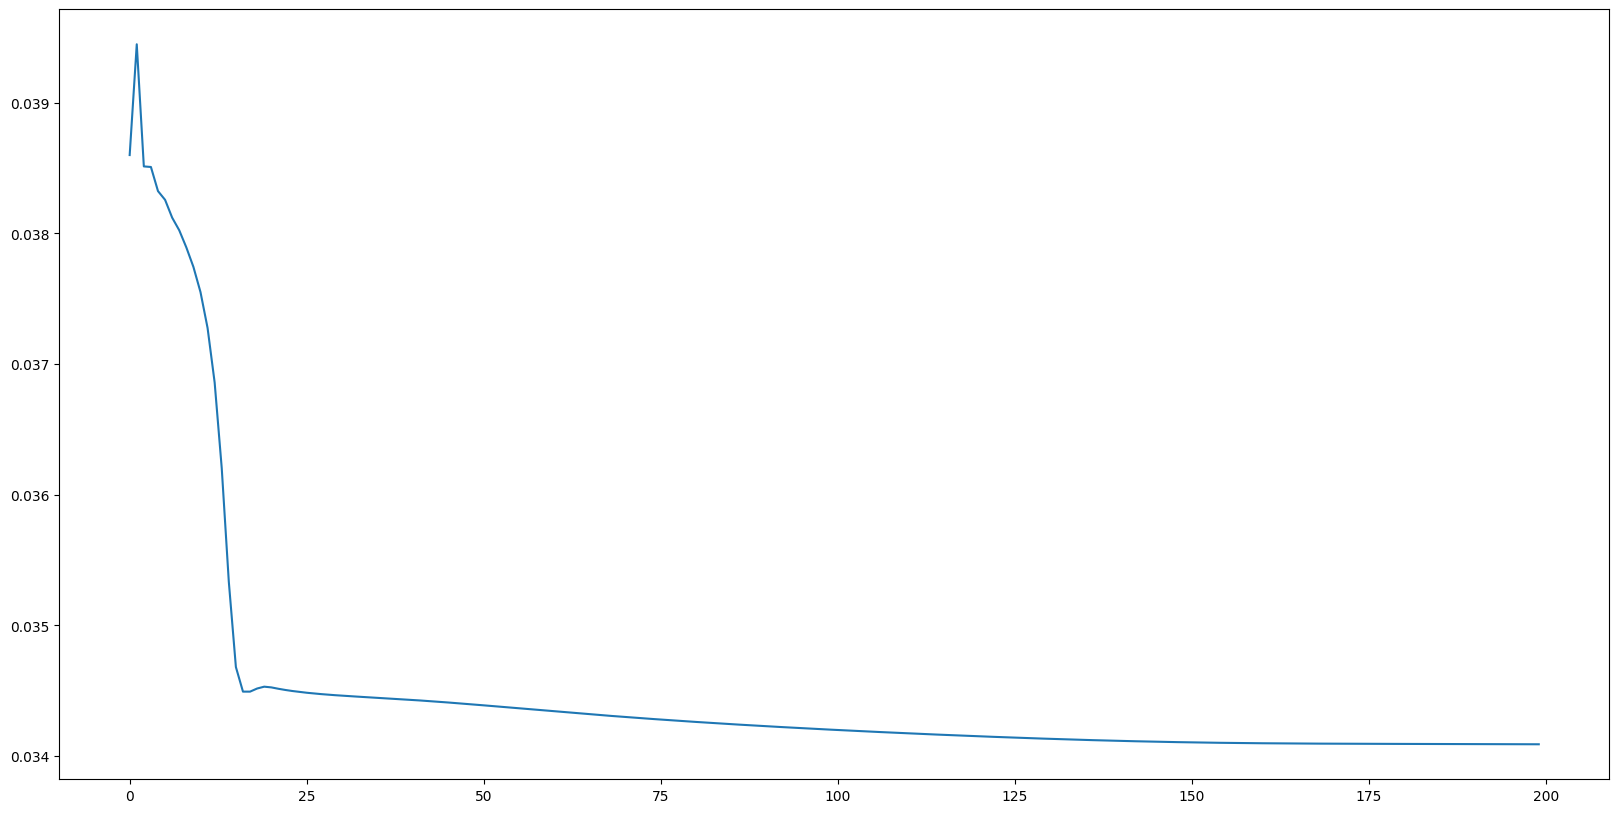

In [78]:
plt.figure(figsize=(20, 10))
plt.plot(loss_graph)
plt.show()

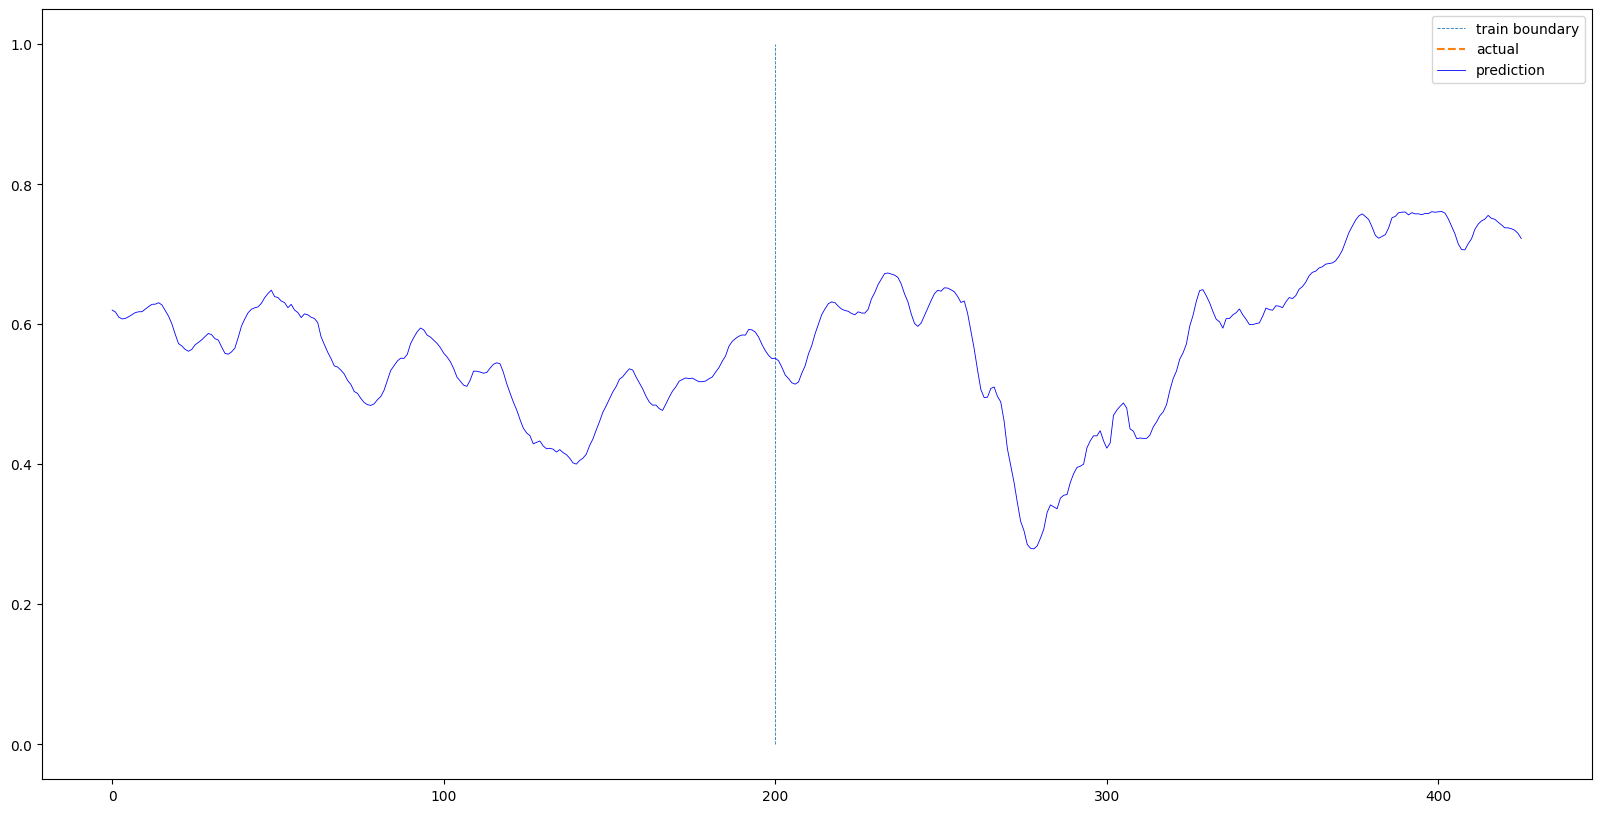

In [79]:
def plotting(train_loader, test_loader, actual):
    with torch.no_grad():
        train_pred = []
        test_pred = []
    
    for data in train_loader:
        seq, target = data
        out = model(seq)
        train_pred += out.cpu().detach().numpy().tolist() # train_loader 에측값
    
    for data in test_loader:
        seq, target = data
        out = model(seq)
        test_pred += out.cpu().detach().numpy().tolist() # test_loader 에측값
    
    total = train_pred + test_pred
    plt.figure(figsize=(20, 10))
    plt.plot(np.ones(100)*len(train_pred), np.linspace(0, 1, 100), '--', linewidth=0.6)
    plt.plot(actual, '--') # actual data 표현
    plt.plot(total, 'b', linewidth=0.6) # train_pred + test_pred data 표현

    plt.legend(['train boundary', 'actual', 'prediction'])
    plt.show()

plotting(train_loader, test_loader, df['Close'][sequence_length])